# SArt - classificador de pinturas

Neste projeto, serão usados conceitos de machine learning a fim de classificar estilos de pinturas de quadros, baseado na leitura da imagem. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models,  Model
import cv2
import os
import PIL
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy

## Base de dados

A base de dados usada foi: https://archive.org/details/wikiart-dataset

São disponibilizadas pastas, nomeadas com um estilo artístico e tendo como conteúdo as obras de arte feitas dentro deste estilo. 

- A estrutura é dada por: `<estilo>/nome-artista_nome-pintura-ano.jpg`
    - Exemplo: `Realism/vincent-van-gogh_pine-trees-in-the-fen-1884.jpg`

O primeiro tratamento feito na base de dados foi excluir movimentos artísticos com um número de obras de arte infferior a 1000. Depois, foram considerados movimentos apenas constituintes de **pinturas**.

Esses cortes foram feitos de maneira manual.

In [2]:
dados = pd.read_excel('wclasses.xlsx')

In [3]:
len(dados)

81444

Além das imagens, o wikiArt disponibiliza um excel, cujas colunas são o path das imagens, ids dos artistas, gênero e estilo.

A lista a seguir possui os nomes dos estilos considerados para o projeto, após aplicarmos os tratamentos citados.

In [4]:
classesList =["Abstrac_Expressionism","Art_Nouveau_Modern","Baroque","Color_Field_Painting","Cubism","Early_Renaissance",
"Expressionism", "Fauvismo","High_Renaissance","Impressionism","Mannerism_Late_Renaissance","Minimalism",
"Naive_Art_Primitivism","Northen_Renaissance","Pop_Art","Post_Impressionism","Realism","Rococo","Romanticism","Symbolism",
"Ukiyo_e"]

Aplicando o filtro com os nomes dos estilos que serão usados:

In [5]:
#impor_membros= dados["file"].str.contains(*classesList)

mask = dados.iloc[:, 0].str.contains(r'\b(?:{})\b'.format('|'.join(classesList)))
df1 = dados[~mask]
len(df1)


8000

In [6]:
df1.head(20)

,file,artist,genre,style
8,Northern_Renaissance/albrecht-durer_deposition...,25,136,157
31,Northern_Renaissance/albrecht-durer_apostle-ba...,25,136,157
46,Northern_Renaissance/albrecht-durer_laughing-p...,25,135,157
60,Northern_Renaissance/albrecht-durer_portrait-o...,25,135,157
61,Northern_Renaissance/albrecht-durer_the-penite...,25,131,157
70,Northern_Renaissance/albrecht-durer_portrait-o...,25,135,157
100,Northern_Renaissance/albrecht-durer_the-great-...,25,131,157
125,Northern_Renaissance/albrecht-durer_portrait-o...,25,135,157
147,Northern_Renaissance/albrecht-durer_portrait-o...,25,135,157
166,Northern_Renaissance/albrecht-durer_portrait-o...,25,135,157


Para que as imagens pudessem ser treinadas, algumas modificações foram feitas: foram retirados acentos dos nomes dos arquivos para facilitar o uso do path das imagens, todas as imagens foram resized para o mesmo tamanho para poderem ser treinadas pelo modelo, e por fim, para facilitar o uso da camada de Dense, os valores de estilo no dataset, que variam entre 140 e 167, foram arrumados para ficar entre 0 e 27.

In [7]:
f = r"D:/Libraries/Documents/Insper/Machine Learning/SArt"
for img_p in range(df1.shape[0]):
    img_path = df1.iloc[img_p, 0]
    if "Ã¢Â\xa0" in img_path:
        img_path = img_path.replace('Ã¢Â', '\u00E2')
        temp_path = img_path.replace('\u00E2', 'a') 
        df1.iat[img_p, 0] = temp_path
        img_path = f  + "/" + img_path
        temp_path = f  + "/" + temp_path
        os.rename(u'{0}'.format(img_path), temp_path)
        img_path = temp_path
    
    df1.iat[img_p, 3] = df1.iloc[img_p, 3]-140
    img = Image.open(img_path)
    img = img.resize((256,256))
    img.save(img_path)

Separação treinamento e teste
- 80% da base de dados destinada a treinamento
- O tipo do id do estilo foi passado de `int` para `str` para possibilitar a classificação  categórica no image data generator.

In [8]:
df1.loc[:,'style'] = df1['style'].astype(str)
print(df1.dtypes)

train = df1.sample(frac=0.8,random_state=200)
test = df1.drop(train.index)

file      object
artist     int64
genre      int64
style     object
dtype: object


C:\Users\Beatriz\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [9]:
print(type(df1.iloc[10, 3]))

<class 'str'>


## Redes neurais 

Para classificar as imagens, foram aplicadas três redes neurais:
- CNN
- LeNet5
- ResNet-152

Os resultados obtidos serão comparados no final.

### Aplicando rede CNN - Convolutional neural network

A rede convolucional foi escolhida, pois é comumente aplicada para análise de imagens visuais. Para essa rede, foi usado o tutorial do próprio tensorflow de classificação de imagens.

A rede convolucional pega um input de imagem e atribui importânca (pesos e vieses que podem ser aprendidos) para features nela, conseguindo diferenciá-los entre si.

O pré-processamento dessa rede é muito menor quando comparado a outros algoritmos de classificação. Enquanto métodos de filtro mais primitivos são hand-engineered (ou seja, feitos à mão), a rede convolucional, com treinamento suficiente, consegue aprender esses filtros.

<img src="rgb_imgcnn.jpg" style="height: 250px;"/>   

<img src="fully_connected_layer.jpg" style="height: 300px;"/>   

In [11]:
im = cv2.imread(train.iloc[4, 0])
print(im.shape)

(256, 256, 3)


A seguir, foram montadas as camadas da rede, conforme explicado no tutorial do tensorflow.

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 230400)            0

O `ImageDataGenerator()` divide os sets em dados que podem ser usados pelo tensorflow. Para validação, são usados 20% dos dados de treino.

In [10]:
target_size=(256,256) # set the size of the images
color_mode='rgb' # set the type of image
class_mode= 'categorical' # set the class mode
batch_size=64  # set the batch size

train_gen = ImageDataGenerator(validation_split=0.2)
test_gen = ImageDataGenerator()

train_imgs= train_gen.flow_from_dataframe(dataframe=train, 
          x_col='file',
          y_col='style',
          target_size=target_size,color_mode=color_mode,
          class_mode=class_mode, batch_size=batch_size,shuffle=True, seed=123,
          subset='training')
val_imgs= train_gen.flow_from_dataframe(dataframe=train, 
          x_col='file',
          y_col='style',
          target_size=target_size,color_mode=color_mode,
          class_mode=class_mode, batch_size=batch_size,shuffle=True, seed=123,
          subset="validation")
test_imgs= test_gen.flow_from_dataframe(dataframe=test, 
          x_col='file',
          y_col='style',
          target_size=target_size,color_mode=color_mode,
          class_mode=class_mode, batch_size=batch_size,shuffle=True, seed=123,
          subset='training')

Found 5120 validated image filenames belonging to 9 classes.
Found 1280 validated image filenames belonging to 9 classes.
Found 1600 validated image filenames belonging to 9 classes.


In [17]:
model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])

history = model.fit(train_imgs, epochs=30, 
                    validation_data=val_imgs)

Epoch 1/30
80/80 [==============================] - 145s 2s/step - loss: 58.0219 - accuracy: 0.3145 - val_loss: 1.9536 - val_accuracy: 0.3836
Epoch 2/30
80/80 [==============================] - 11s 137ms/step - loss: 1.6617 - accuracy: 0.4658 - val_loss: 1.9019 - val_accuracy: 0.3531
Epoch 3/30
80/80 [==============================] - 11s 137ms/step - loss: 1.1880 - accuracy: 0.6244 - val_loss: 2.1755 - val_accuracy: 0.3492
Epoch 4/30
80/80 [==============================] - 12s 149ms/step - loss: 0.7276 - accuracy: 0.7760 - val_loss: 2.5834 - val_accuracy: 0.3344
Epoch 5/30
80/80 [==============================] - 11s 139ms/step - loss: 0.4332 - accuracy: 0.8754 - val_loss: 3.6697 - val_accuracy: 0.3187
Epoch 6/30
80/80 [==============================] - 11s 137ms/step - loss: 0.3006 - accuracy: 0.9225 - val_loss: 3.9536 - val_accuracy: 0.3289
Epoch 7/30
80/80 [==============================] - 11s 138ms/step - loss: 0.2612 - accuracy: 0.9328 - val_loss: 4.4165 - val_accuracy: 0.3219


25/25 - 41s - loss: 10.4730 - accuracy: 0.3169 - 41s/epoch - 2s/step


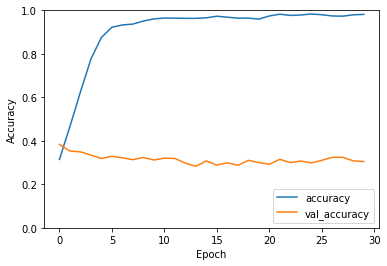

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_imgs, verbose=2)

O gráfico acima mostra a acurácia para os dados de treino (em azul) e dados de teste (em laranja). Como se pode ver, a acurácia dos dados de treino se apresenta maior, dado que o modelo está com overfitting, ou seja, para dados fora daqueles usados para o treinamento, o modelo não conseguiu obter um bom ajuste.

### Aplicando LeNet5

**LeNet5** é uma estrutura de rede neural convolucional, introduzida no paper _"Gradient-Based Learning Applied To Document Recognition"_ em 1998, de autoria de Yann LeCun, Leon Bottou, Yoshua Bengio e Patrick Haffner.

Como será mostrado a seguir, a LeNet5 é composta por 7 layers, cuja composição é:
- 3 layers convolucionais
- 2 layers de subamostragem
- 2 layers totalmente conectados

<img src="LeNetArchitecture.jpg" style="height: 250px;"/>   

A seguir, são montadas as camadas, conforme a estrutura da rede.

In [19]:
LeNet5 = tf.keras.Sequential()

LeNet5.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)))
LeNet5.add(layers.AveragePooling2D())

LeNet5.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
LeNet5.add(layers.AveragePooling2D())

LeNet5.add(layers.Flatten())

LeNet5.add(layers.Dense(120, activation='relu'))

LeNet5.add(layers.Dense(84, activation='relu'))

LeNet5.add(layers.Dense(9, activation = 'softmax'))

LeNet5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 average_pooling2d (AverageP  (None, 127, 127, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 16)      880       
                                                                 
 average_pooling2d_1 (Averag  (None, 62, 62, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 61504)             0         
                                                                 
 dense_2 (Dense)             (None, 120)              

In [31]:
LeNet5.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])

historyLeNet5 = LeNet5.fit(train_imgs, epochs=30, 
                    validation_data=val_imgs)

Epoch 1/30
80/80 [==============================] - 13s 155ms/step - loss: 23.3071 - accuracy: 0.3393 - val_loss: 1.6006 - val_accuracy: 0.4547
Epoch 2/30
80/80 [==============================] - 12s 155ms/step - loss: 1.1315 - accuracy: 0.6326 - val_loss: 1.5324 - val_accuracy: 0.5008
Epoch 3/30
80/80 [==============================] - 12s 152ms/step - loss: 0.5328 - accuracy: 0.8506 - val_loss: 1.6160 - val_accuracy: 0.5312
Epoch 4/30
80/80 [==============================] - 12s 151ms/step - loss: 0.2276 - accuracy: 0.9512 - val_loss: 1.8558 - val_accuracy: 0.5336
Epoch 5/30
80/80 [==============================] - 12s 151ms/step - loss: 0.1083 - accuracy: 0.9824 - val_loss: 2.0627 - val_accuracy: 0.5156
Epoch 6/30
80/80 [==============================] - 12s 155ms/step - loss: 0.0754 - accuracy: 0.9936 - val_loss: 2.2474 - val_accuracy: 0.5352
Epoch 7/30
80/80 [==============================] - 12s 152ms/step - loss: 0.0538 - accuracy: 0.9949 - val_loss: 2.3286 - val_accuracy: 0.522

25/25 - 3s - loss: 3.1853 - accuracy: 0.5400 - 3s/epoch - 130ms/step


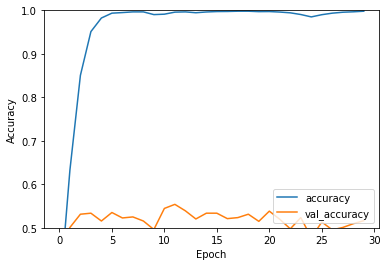

In [33]:
plt.plot(historyLeNet5.history['accuracy'], label='accuracy')
plt.plot(historyLeNet5.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = LeNet5.evaluate(test_imgs, verbose=2)

Como mostrado no gráfico acima, também se apresentou overfitting, com a acurácia do treinamento muito maior do que no caso do teste. Porém, já é visível que ambas as acurácias aumentaram, com a acurácia de teste em 54%.

### Aplicando ResNet152

ResNet é uma ANN (artificial neural network), variante da HigwayNet (https://en.wikipedia.org/wiki/Highway_network). Pode possuir centenas de camadas, sendo muito mais profunda do que redes neurais anteriores. São usados conexões de salto ou atalhos ​​para saltar sobre algumas camadas. Modelos ResNet típicos são implementados com saltos de camada dupla ou tripla que contêm não linearidades (ReLU) e normalização de lote no meio. Modelos com vários saltos paralelos são referidos como DenseNets.

<img src="File_ResNets.png" style="height: 300px;"/>   

Forma canônica de uma rede neural residual. Uma camada ℓ   − 1 é ignorada na ativação de ℓ  − 2.

#### Arquitetura ResNet:

<img src="arquitetura_resnet.png" style="height: 350px;"/>   

_ResNet de 34 camadas com conexão Skip/Atalho (superior), rede simples de 34 camadas (meio), VGG-19 de 19 camadas (inferior)_

O VGG-19 [2] (abaixo na imagem) é uma abordagem de última geração no ILSVRC 2014.
A rede plana de 34 camadas (no meio) é tratada como a rede mais profunda do VGG-19 , ou seja, camadas mais convolucionais.
A rede residual de 34 camadas (ResNet) (topo) é a simples com adição de conexão skip/atalho.

A ResNet usada é de grande profundidade, contendo **152** camadas.

In [21]:
ResNet = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (256,256,3))
for layer in ResNet.layers:
  layer.trainable = False

In [22]:
x = layers.Flatten()(ResNet.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(9, activation = 'softmax')(x)

In [28]:
ResNetModel = Model(inputs = ResNet.input, outputs = predictions)
ResNetModel.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

In [30]:
historyResNet = ResNetModel.fit(train_imgs, epochs=30, validation_data=(val_imgs))

Epoch 1/30
80/80 [==============================] - 36s 455ms/step - loss: 0.1372 - accuracy: 0.9631 - val_loss: 0.6996 - val_accuracy: 0.8164
Epoch 2/30
80/80 [==============================] - 29s 364ms/step - loss: 0.0461 - accuracy: 0.9914 - val_loss: 0.7178 - val_accuracy: 0.8320
Epoch 3/30
80/80 [==============================] - 29s 365ms/step - loss: 0.0141 - accuracy: 0.9977 - val_loss: 0.7267 - val_accuracy: 0.8391
Epoch 4/30
80/80 [==============================] - 34s 425ms/step - loss: 0.0135 - accuracy: 0.9982 - val_loss: 0.7364 - val_accuracy: 0.8352
Epoch 5/30
80/80 [==============================] - 34s 422ms/step - loss: 0.0133 - accuracy: 0.9977 - val_loss: 0.7736 - val_accuracy: 0.8453
Epoch 6/30
80/80 [==============================] - 30s 378ms/step - loss: 0.0172 - accuracy: 0.9979 - val_loss: 0.7814 - val_accuracy: 0.8383
Epoch 7/30
80/80 [==============================] - 32s 394ms/step - loss: 0.0155 - accuracy: 0.9973 - val_loss: 0.8119 - val_accuracy: 0.8391

25/25 - 7s - loss: 0.8478 - accuracy: 0.8462 - 7s/epoch - 281ms/step


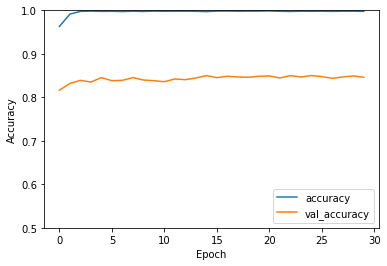

In [31]:
plt.plot(historyResNet.history['accuracy'], label='accuracy')
plt.plot(historyResNet.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = ResNetModel.evaluate(test_imgs, verbose=2)

No gráfico acima já é possível ver que, apesar de a ResNet prover resultados muito mais satisfatórios, com uma acurácia para teste de 84%, ainda existe um overfitting no modelo. Como vimos que todos os modelos possuem um grau de overfitting, tentamos lidar com isso nos próximos passos.

### Lidando com OverFitting

Em todos os modelos testados, foi analisado um certo overfitting. Como uma CNN está sendo utilizada, que auto-ajusta os hiperparâmetros, é muito difícil ajustá-los diretamente para melhorar a situação. Portanto, foi feita uma Regressão Ridge, adicionando nas camadas de Conv2D e Dense o parâmetro kernel_regularizer, que aplica penalidades nos parâmetros das camadas individuais, no caso ajustando o parâmetro L2. Esse parâmetro foi aplicado nas layers dos modelos da CNN padrão e da LeNet5, já que as layers desses modelos são delimitadas manualmente, enquanto no ResNet foi utilizado um modelo já pronto da biblioteca do tensorflow que dificulta a mudança direta das camadas.

In [11]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3), kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model2.add(layers.Dense(9, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 230400)            0

In [12]:
LeNet52 = tf.keras.Sequential()
LeNet52.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3), kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
LeNet52.add(layers.AveragePooling2D())
LeNet52.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
LeNet52.add(layers.AveragePooling2D())
LeNet52.add(layers.Flatten())
LeNet52.add(layers.Dense(120, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
LeNet52.add(layers.Dense(84, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
LeNet52.add(layers.Dense(9, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
LeNet52.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 average_pooling2d (AverageP  (None, 127, 127, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 16)      880       
                                                                 
 average_pooling2d_1 (Averag  (None, 62, 62, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 61504)             0         
                                                                 
 dense_2 (Dense)             (None, 120)              

In [13]:
model2.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])

history2 = model2.fit(train_imgs, epochs=30, 
                    validation_data=val_imgs)

Epoch 1/30
80/80 [==============================] - 26s 277ms/step - loss: 49.0814 - accuracy: 0.3283 - val_loss: 6.0993 - val_accuracy: 0.3711
Epoch 2/30
80/80 [==============================] - 12s 154ms/step - loss: 5.5377 - accuracy: 0.4414 - val_loss: 5.5429 - val_accuracy: 0.3414
Epoch 3/30
80/80 [==============================] - 11s 141ms/step - loss: 4.8807 - accuracy: 0.5664 - val_loss: 5.4689 - val_accuracy: 0.3477
Epoch 4/30
80/80 [==============================] - 12s 149ms/step - loss: 4.3288 - accuracy: 0.6695 - val_loss: 5.5383 - val_accuracy: 0.3406
Epoch 5/30
80/80 [==============================] - 11s 133ms/step - loss: 3.7638 - accuracy: 0.7781 - val_loss: 5.5166 - val_accuracy: 0.3234
Epoch 6/30
80/80 [==============================] - 11s 134ms/step - loss: 3.4814 - accuracy: 0.8283 - val_loss: 5.9052 - val_accuracy: 0.3461
Epoch 7/30
80/80 [==============================] - 11s 133ms/step - loss: 3.1770 - accuracy: 0.8660 - val_loss: 5.8269 - val_accuracy: 0.328

In [14]:
LeNet52.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])

historyLeNet52 = LeNet52.fit(train_imgs, epochs=30, 
                    validation_data=val_imgs)

Epoch 1/30
80/80 [==============================] - 12s 145ms/step - loss: 62.2379 - accuracy: 0.3010 - val_loss: 5.8455 - val_accuracy: 0.4109
Epoch 2/30
80/80 [==============================] - 11s 138ms/step - loss: 5.0915 - accuracy: 0.4748 - val_loss: 5.0880 - val_accuracy: 0.4313
Epoch 3/30
80/80 [==============================] - 11s 139ms/step - loss: 4.3872 - accuracy: 0.5762 - val_loss: 4.7381 - val_accuracy: 0.4766
Epoch 4/30
80/80 [==============================] - 11s 141ms/step - loss: 3.8466 - accuracy: 0.6715 - val_loss: 4.5965 - val_accuracy: 0.4664
Epoch 5/30
80/80 [==============================] - 11s 136ms/step - loss: 3.5260 - accuracy: 0.7475 - val_loss: 4.6471 - val_accuracy: 0.4930
Epoch 6/30
80/80 [==============================] - 11s 135ms/step - loss: 3.3092 - accuracy: 0.7906 - val_loss: 4.5747 - val_accuracy: 0.4617
Epoch 7/30
80/80 [==============================] - 11s 136ms/step - loss: 2.9884 - accuracy: 0.8520 - val_loss: 4.6346 - val_accuracy: 0.457

25/25 - 3s - loss: 5.8827 - accuracy: 0.3294 - 3s/epoch - 109ms/step


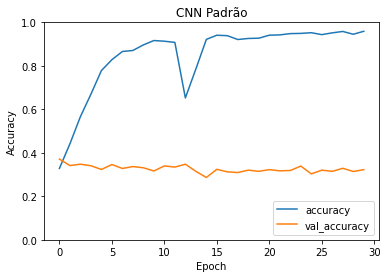

In [15]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.title('CNN Padrão')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model2.evaluate(test_imgs, verbose=2)

25/25 - 3s - loss: 3.8638 - accuracy: 0.4737 - 3s/epoch - 109ms/step


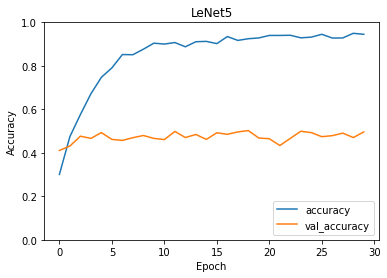

In [18]:
plt.plot(historyLeNet52.history['accuracy'], label='accuracy')
plt.plot(historyLeNet52.history['val_accuracy'], label = 'val_accuracy')
plt.title('LeNet5')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = LeNet52.evaluate(test_imgs, verbose=2)

Após aplicar a Regressão Ridge os modelos, é possível notar uma leve melhoria na acurácia da CNN padrão, subindo para 33%, mas um desempenho pior no caso da LeNet5, cuja acurácia caiu ara 47%. O overfitting ainda é presente.

Para diminuir o overfitting da ResNet, na hora de gerar os sets utilizáveis com o tensorflow com o `ImageDataGenerator`, foi adicionado outro parâmetro: tf.keras.applications.resnet.preprocess_input. Esse parâmetro é próprio da biblioteca de ResNet do Keras, e ele melhora o pré-processamento das imagens para serem utilizadas no modelo.

In [40]:
target_size=(256,256) # set the size of the images
color_mode='rgb' # set the type of image
class_mode= 'categorical' # set the class mode
batch_size=64  # set the batch size
subset='training' # set to 'training', or 'valiatiom' or leave as None

train_gen = ImageDataGenerator(validation_split=0.2, preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_imgs= train_gen.flow_from_dataframe(dataframe=train, 
          x_col='file',
          y_col='style',
          target_size=target_size,color_mode=color_mode,
          class_mode=class_mode, batch_size=batch_size,shuffle=True, seed=123,
          subset='training')
val_imgs= train_gen.flow_from_dataframe(dataframe=train, 
          x_col='file',
          y_col='style',
          target_size=target_size,color_mode=color_mode,
          class_mode=class_mode, batch_size=batch_size,shuffle=True, seed=123,
          subset="validation")
test_imgs= test_gen.flow_from_dataframe(dataframe=test, 
          x_col='file',
          y_col='style',
          target_size=target_size,color_mode=color_mode,
          class_mode=class_mode, batch_size=batch_size,shuffle=True, seed=123,
          subset='training')

Found 5120 validated image filenames belonging to 9 classes.
Found 1280 validated image filenames belonging to 9 classes.
Found 1600 validated image filenames belonging to 9 classes.


In [44]:
ResNetModel2 = Model(inputs = ResNet.input, outputs = predictions)
ResNetModel2.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

In [46]:
historyResNet2 = ResNetModel2.fit(train_imgs, epochs=30, validation_data=(val_imgs))

Epoch 1/30
80/80 [==============================] - 32s 395ms/step - loss: 0.0445 - accuracy: 0.9910 - val_loss: 1.7304 - val_accuracy: 0.8391
Epoch 2/30
80/80 [==============================] - 27s 335ms/step - loss: 0.0426 - accuracy: 0.9924 - val_loss: 1.7177 - val_accuracy: 0.8484
Epoch 3/30
80/80 [==============================] - 27s 335ms/step - loss: 0.0582 - accuracy: 0.9914 - val_loss: 1.6331 - val_accuracy: 0.8547
Epoch 4/30
80/80 [==============================] - 27s 335ms/step - loss: 0.0312 - accuracy: 0.9955 - val_loss: 1.8157 - val_accuracy: 0.8484
Epoch 5/30
80/80 [==============================] - 27s 337ms/step - loss: 0.0362 - accuracy: 0.9930 - val_loss: 1.6656 - val_accuracy: 0.8594
Epoch 6/30
80/80 [==============================] - 27s 343ms/step - loss: 0.0469 - accuracy: 0.9916 - val_loss: 1.6952 - val_accuracy: 0.8578
Epoch 7/30
80/80 [==============================] - 51s 639ms/step - loss: 0.0261 - accuracy: 0.9922 - val_loss: 1.9872 - val_accuracy: 0.8422

25/25 - 7s - loss: 2.1567 - accuracy: 0.8550 - 7s/epoch - 296ms/step


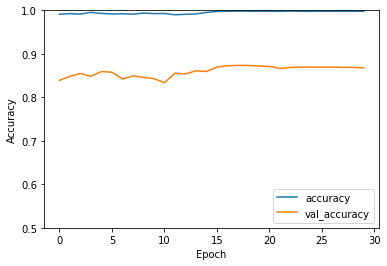

In [50]:
plt.plot(historyResNet2.history['accuracy'], label='accuracy')
plt.plot(historyResNet2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = ResNetModel2.evaluate(test_imgs, verbose=2)

No gráfico acima, é possível ver uma leve melhoria no modelo, com a acurácia de teste subindo para 85%, mas o overfitting continua presente. 

Em seguida, também foi tentada outra técnica, modificando a learning rate do optimizador do modelo.

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

ResNetModel3 = Model(inputs = ResNet.input, outputs = predictions)
ResNetModel3.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])

historyResNet3 = ResNetModel3.fit(train_imgs, epochs=30, validation_data=(val_imgs))

Epoch 1/30
80/80 [==============================] - 37s 367ms/step - loss: 64.2344 - accuracy: 0.6738 - val_loss: 4.2921 - val_accuracy: 0.8062
Epoch 2/30
80/80 [==============================] - 26s 326ms/step - loss: 1.2502 - accuracy: 0.9260 - val_loss: 4.8609 - val_accuracy: 0.7828
Epoch 3/30
80/80 [==============================] - 27s 337ms/step - loss: 0.4279 - accuracy: 0.9678 - val_loss: 4.4109 - val_accuracy: 0.8344
Epoch 4/30
80/80 [==============================] - 27s 342ms/step - loss: 0.3727 - accuracy: 0.9736 - val_loss: 4.8707 - val_accuracy: 0.8398
Epoch 5/30
80/80 [==============================] - 26s 323ms/step - loss: 0.3948 - accuracy: 0.9736 - val_loss: 5.4406 - val_accuracy: 0.8336
Epoch 6/30
80/80 [==============================] - 26s 322ms/step - loss: 0.2583 - accuracy: 0.9816 - val_loss: 5.0818 - val_accuracy: 0.8094
Epoch 7/30
80/80 [==============================] - 26s 322ms/step - loss: 0.2358 - accuracy: 0.9861 - val_loss: 5.7619 - val_accuracy: 0.808

25/25 - 7s - loss: 6.6702 - accuracy: 0.8250 - 7s/epoch - 273ms/step


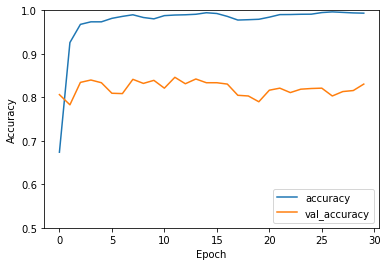

In [26]:
plt.plot(historyResNet3.history['accuracy'], label='accuracy')
plt.plot(historyResNet3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = ResNetModel3.evaluate(test_imgs, verbose=2)

Porém, como vemos acima, essa técnica diminuiu a acurácia do modelo para 82%, piorando o seu desempenho.

Apesar das técnicas aplicadas, os modelos ainda apresentam overfit em seus resultados. Para melhora-los é possível aplicar outras técnicas, como restringir o aprendizado do modelo por epoch, limitar o peso máximo do modelo, utilizar diferentes pesos de inicialização utilizar data augmentation a fim se ter mais dados para o treinamento e teste.